# Develop system

In [1]:
import os
import uuid
from typing import Sequence, Annotated
from typing_extensions import TypedDict
from IPython.display import Image, display

from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage, AIMessage
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings, HuggingFaceEndpoint

from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langchain_chroma import Chroma
from dotenv import load_dotenv, find_dotenv

In [2]:
load_dotenv(find_dotenv())

True

### Setup RAG system

Functions to call llm

In [3]:
def get_openai_models():
    """
    Returns a ChatOpenAI LLM and OpenAIEmbeddings instance.
    """
    OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
    assert OPENAI_API_KEY, "Please set OPENAI_API_KEY environment variable"
    llm = ChatOpenAI(model="gpt-4o-mini")
    embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
    return llm, embeddings

def get_opensource_models():
    """
    Returns a HuggingFaceEndpoint LLM and HuggingFaceEmbeddings instance.
    Uses the Mistral-7B-Instruct model and a sentence-transformers model for embeddings.
    """
    HUGGINGFACEHUB_API_TOKEN = os.getenv("HUGGINGFACEHUB_API_TOKEN")
    assert HUGGINGFACEHUB_API_TOKEN, "Please set HUGGINGFACEHUB_API_TOKEN environment variable"
    endpoint_url = "https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2"
    llm = HuggingFaceEndpoint(
        endpoint_url=endpoint_url,
        huggingfacehub_api_token=HUGGINGFACEHUB_API_TOKEN
    )
    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    return llm, embeddings

In [4]:
provider = os.getenv("USE_PROVIDER", "huggingface").lower()
if provider == "openai":
    llm, embeddings = get_openai_models()
    vectorstore = Chroma(
        persist_directory='./openai_chroma_langchain_db', 
        embedding_function=embeddings, 
        collection_name='openai_embeddings'
    )
elif provider == "huggingface":
    llm, embeddings = get_opensource_models()
    vectorstore = Chroma(
        persist_directory='./huggingface_chroma_langchain_db', 
        embedding_function=embeddings, 
        collection_name='huggingface_embeddings'
    )
else:
    raise ValueError("Unknown provider specified. Use 'openai' or 'huggingface'.")

/home/matt/miniconda3/envs/py311_ASKiT/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 3})

In [6]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    meta: dict

In [7]:
def retrieval_node(state: AgentState):
    """
    Retrieves relevant documents using the retriever.
    It then appends a ToolMessage containing detailed content (including metadata) from the documents.
    """
    query = state["messages"][-1].content
    docs = retriever.invoke(query)
    tool_call_id = str(uuid.uuid4())
    # Enrich each document chunk with a title (or default value)
    detailed_content = "\n\n".join(
        f"Title: {doc.metadata.get('title', 'test_document')}\nContent: {doc.page_content}"
        for doc in docs
    )
    tool_message = ToolMessage(
        content=detailed_content,
        name="stored_documents_retrieved",
        tool_call_id=tool_call_id
    )
    return {"messages": [tool_message]}

In [8]:
def retrieve_latest_message_typ(state: AgentState, message_type):
    """
    Helper function to retrieve the latest message of a given type.
    """
    latest_message = next(
        (msg for msg in reversed(state["messages"]) if isinstance(msg, message_type)),
        None
    )
    if latest_message is None:
        raise ValueError(f"No message found of type {message_type}")
    return latest_message

In [9]:
def generate_answer_node(state: AgentState):
    """
    Uses the latest ToolMessage (context) and HumanMessage (query) to construct a prompt,
    then invokes the LLM to generate an answer.
    """
    context = retrieve_latest_message_typ(state, ToolMessage).content
    query = retrieve_latest_message_typ(state, HumanMessage).content
    prompt = f"""
    You are a helpful assistant answering queries based strictly on the context provided.

    Context:
    {context}

    Query: {query}
    """
    # Assume that llm.invoke returns an AIMessage.
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [10]:
def agent_router(state: AgentState):
    """
    Determines the next step. Currently hardcoded to always route to retrieval.
    Returns an AIMessage containing the routing decision.
    """
    needs_retrieval = True  # This can be replaced with LLM logic later.
    next_step = "retrieve" if needs_retrieval else END
    routing_message = AIMessage(content=next_step)
    return {"messages": [routing_message]}

In [11]:
graph = StateGraph(AgentState)

# Add nodes to the graph.
graph.add_node("agent_router", agent_router)
graph.add_node("retrieve", retrieval_node)
graph.add_node("generate", generate_answer_node)

# Set the entry point.
graph.set_entry_point("agent_router")

# Add conditional edges using a lambda that extracts the routing decision from the latest AIMessage.
graph.add_conditional_edges(
    "agent_router",
    lambda state: retrieve_latest_message_typ(state, AIMessage).content,
    path_map={
        "retrieve": "retrieve",
        END: END
    }
)

# Define sequential edges.
graph.add_edge("retrieve", "generate")
graph.set_finish_point("generate")

# Compile the app.
app = graph.compile()

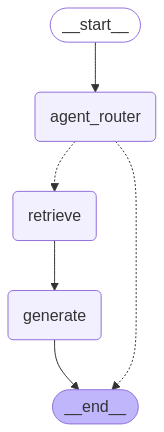

In [12]:
display(Image(app.get_graph().draw_mermaid_png()))

In [13]:
initial_state: AgentState = {
    "messages": [
        HumanMessage(content="What are some best practices when building langgraph workflows?")
    ],
    "meta": {"provider": provider}
}

In [14]:
result = app.invoke(initial_state)

/home/matt/miniconda3/envs/py311_ASKiT/lib/python3.11/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


In [15]:
result

{'messages': [HumanMessage(content='What are some best practices when building langgraph workflows?', additional_kwargs={}, response_metadata={}, id='7f2461fc-3de7-48aa-89b2-9009cd668fc6'),
  AIMessage(content='retrieve', additional_kwargs={}, response_metadata={}, id='eb9185da-0c6f-44e8-95cf-728599d0071b'),
  ToolMessage(content='Title: test_document\nContent: Best Practices for Graph Structure and State\n\nWhen building LangGraph workflows, keep these best practices in mind:\n\n    Design a clear State schema: Define your state’s structure up front (using a TypedDict, Pydantic model, or dataclass) to list all fields that nodes will use. This makes it clear what data flows through the graph and helps avoid key collisions or missing data.\n\n    Return state updates from nodes: Each node function should return a dictionary of updates to the state. Only the keys returned will be updated or added to the shared state\u200b\n    stackoverflow.com\n    . For example, if your state has a fie